In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad, quad_vec, cumulative_trapezoid, simpson
from tqdm import tqdm
import timeit

In [237]:
"""
Constants
"""
# --> Pulse <--
wl = 0.057                      # au
epsilon = 1
intensity = 10e13 / 3.51e16     # au
phi = np.pi
Nc = 1
T = Nc * 2*np.pi/wl

F0 = np.sqrt(intensity)
A0 = F0 / wl

Up = A0**2 * 0.25

def envelope(t) : 
    global wl, Nc, T
    return np.sin(np.pi*t/T)**2

# --> System <--
E0 = -0.5                       # au


In [238]:
def make_grid(yrange, zrange, nmb_pns) : 
    ylin = np.linspace(yrange[0], yrange[1], nmb_pns)
    zlin = np.linspace(zrange[0], zrange[1], nmb_pns)
    return ylin, zlin

In [239]:
def time_evolution(tp, t0) : 
    global E0
    return np.exp( -1j*E0*(tp-t0) ) 

def A(t: np.array) : 
    global A0, epsilon, phi, Nc
    prefac = A0 * envelope(t) / ( np.sqrt( 1 + epsilon**2) )

    vec = np.stack([
                    np.zeros_like(t), 
                    epsilon*np.sin(wl*t+phi),
                    np.cos(wl*t+phi)
    ], axis=0)

    # returns: (3, len(t))
    return prefac * vec

def get_alpha_and_betas(tps: np.array, t0: float, N: int) : 
    alpha_list = np.zeros(shape=(len(tps),3,))
    beta_list = np.zeros_like(tps)

    for i, tp in enumerate(tps) : 
        tgrid = np.linspace(t0, tp, N)
        A_of_ts = A(tgrid)
        A2_of_ts = np.sum(A_of_ts**2, axis=0)  # shape: (len(tps),)

        alpha = simpson(y=A_of_ts, x=tgrid)
        beta = simpson(y=A2_of_ts, x=tgrid)
        #print(beta)
        
        alpha_list[i] = alpha
        beta_list[i] = beta

    # returns: 
    # alpha_list: (len(tps),3)
    # beta_list: (len(tps),)
    return (alpha_list, beta_list)

def ground_state_fourier(k: np.array) : 
    return 2**(5/2)/(2*np.pi) * 1/( np.dot(k,k) +1)**2

def matrix_element(t: float, t0: float, k_range: np.array, N: int, time_N: int) : 
    # Time grid
    ts = np.linspace(t0, t, time_N)
    # Precompute alpha and beta
    alphas, betas = get_alpha_and_betas(ts, t0, time_N)
    A_tgrid = A(ts) # each column is Ax(t1), Ay(t1), Az(t1)

    # k-vectors
    k_ys = np.linspace(k_range[0], k_range[1], N)
    k_zs = np.linspace(k_range[0], k_range[1], N)

    result = np.zeros((N, N))

    for i, k_y in tqdm(enumerate(k_ys)) : 
        for j, k_z in enumerate(k_zs) : 
            k_vector = np.array([0.0, k_y, k_z])
            k2 = k_vector.dot(k_vector)
            
            prod = np.dot(A_tgrid.transpose(), k_vector)
            
            state = np.exp( -1j*0.5*k2*(ts-t0) 
                           + 1j*np.dot(alphas, k_vector) 
                           + 1j*0.5*betas ) * time_evolution(ts, t0)

            integrand = prod * state

            # Do simpson integration
            integral = simpson(y=integrand, x=ts)

            res = -1j * ground_state_fourier(k_vector) * integral

            result[i,j] = np.abs(res)**2
    
    return ts, A_tgrid, k_ys, k_zs, result     


In [240]:

threshold = 2.0*np.sqrt(Up)
ts, A_ts, k_ys, k_zs, matrix = matrix_element(t=T, t0=0.0, k_range=[-threshold, threshold], N=200, time_N=1000)

200it [00:04, 49.89it/s]


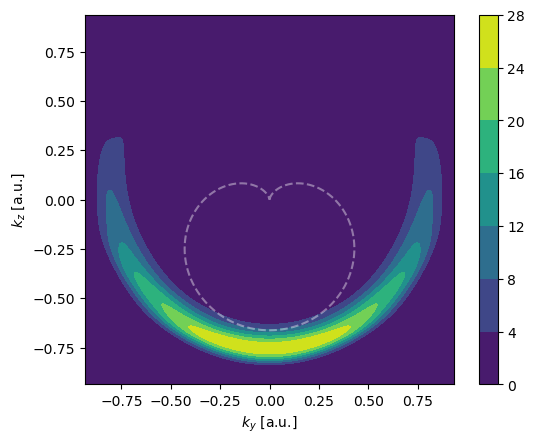

In [241]:
Z, Y = np.meshgrid(k_ys, k_zs)

fig, ax = plt.subplots()

A2 = np.sum(A_ts**2, axis=0)

A_ys = - A_ts[1] 
A_zs = - A_ts[2] 

ax.plot(A_ys, A_zs, 'w--', alpha=0.4)
ax.contourf(Y, Z, matrix)

ax.set_xlabel("$k_y$ [a.u.]")
ax.set_ylabel("$k_z$ [a.u.]")

# Store the contourf object
cf = ax.contourf(Y, Z, matrix)
fig.colorbar(cf, ax=ax)

ax.set_aspect('equal')

In [171]:
x = np.array([[1,1,1,1],
              [2,2,2,2],
              [3,3,3,3]])
print(x[:,0])

[1 2 3]
